In [14]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

tf.compat.v1.disable_eager_execution()
K.clear_session()

# 注意，网络中包括了密集连接分类器。在前面所有的例子中，我们都舍弃了这个分类器
model = VGG16(weights='imagenet')

In [15]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '../../data/Downloads/creative_commons_elephant.png'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# 添加一个维度，将数组转换为(1, 224, 224, 3) 形状的批量
x = np.expand_dims(x, axis=0)

# 对批量进行预处理（按通道进行颜色标准化）
x = preprocess_input(x)

In [16]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.90988594), ('n01871265', 'tusker', 0.085724816), ('n02504013', 'Indian_elephant', 0.00434713)]


C:\Users\machengjun\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [17]:
# 应用 Grad-CAM 算法
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

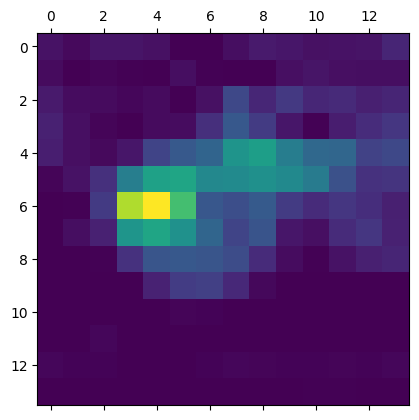

In [18]:
import matplotlib.pyplot as plt

# 热力图后处理
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [19]:
# 用 OpenCV 来生成一张图像，将原始图像叠加在刚刚得到的热力图上
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('../../data/Downloads/elephant_cam.jpg', superimposed_img)

True

![elephants](../../data/Downloads/elephant_cam.jpg)